In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline  
pd.options.mode.chained_assignment = None  # default='warn'

In [116]:
regenerate_betas = False

In [117]:
# Read the .csv with data for each state
df = pd.DataFrame.from_csv('Apps/PlainText 2/538.csv')
dfstates = df[df.index != 'National']
if regenerate_betas:
    dfstates["Beta"] = np.nan
else:
    dfbetas = pd.DataFrame.from_csv('Apps/PlainText 2/betas538.csv')
    dfstates = pd.concat([dfstates, dfbetas], axis=1, join='inner')
dfexitpolls = pd.DataFrame.from_csv('Apps/PlainText 2/538-exitpolls.csv').fillna(0)
dfstates = pd.concat([dfstates,dfexitpolls], axis=1, join='inner')
dfstates.head()

,Code,Votes,Hprob,Tprob,Jprob,Mprob,Hvotes,Tvotes,Jvotes,Mvotes,Ovotes,Beta,PercIn,Hreal,Treal
State,,,,,,,,,,,,,,,
Alabama,AL,9,0.0030,0.9970,0.0,0.0,0.371,0.584,0.028,0.0,0.017,163.483366,0.7,0.42,0.66
Alaska,AK,3,0.2783,0.7217,0.0,0.0,0.412,0.474,0.098,0.0,0.016,73.113397,0.0,0.00,0.00
Arizona,AZ,11,0.3600,0.6400,0.0,0.0,0.457,0.477,0.053,0.0,0.013,291.815541,0.0,0.00,0.00
Arkansas,AR,6,0.0070,0.9930,0.0,0.0,0.375,0.559,0.049,0.0,0.017,160.000000,0.0,0.00,0.00
California,CA,55,0.9990,0.0010,0.0,0.0,0.589,0.353,0.042,0.0,0.016,157.139943,0.0,0.00,0.00


In [118]:
n_sims = 20000

In [119]:
# Loop over alle staten
betas = [2.5,4,6.3,10,16,25,40,63,100,160,250,400,630,1000,1600,2500]

if regenerate_betas:
    for index, row in dfstates.iterrows():

        # Pak de vote percentages van deze staat en sla de win percentages op volgens 538
        ratios = row.loc[['Hvotes','Tvotes','Jvotes','Mvotes','Ovotes']].as_matrix()
        hwinperc_538 = row.loc[['Hprob']][0]
        twinperc_538 = row.loc[['Tprob']][0]

        results = []
        # Loop over mogelijke waardes van beta om de juiste beta te bepalen

        for beta in betas:
            # Loop over de verschillende simulaties
            sims = pd.DataFrame(np.random.dirichlet((ratios*beta).tolist(),n_sims).tolist())
            sims['Hwin'] = sims.apply(lambda row: row[0] == max(row), axis=1)
            sims['Twin'] = sims.apply(lambda row: row[1] == max(row), axis=1)
            hwinperc = len(sims[sims['Hwin'] == True])/float(n_sims)
            twinperc = len(sims[sims['Twin'] == True])/float(n_sims)

            # Sla de resultaten voor deze waarde van beta op
            results.append([beta,hwinperc,twinperc])
        c = np.log(np.asarray(results))
        c = c[c[:,1].argsort()]
        new_beta1 = np.exp(np.interp(np.log(hwinperc_538),c[:,1],c[:,0]))
        c = c[c[:,2].argsort()]
        new_beta2 = np.exp(np.interp(np.log(twinperc_538),c[:,2],c[:,0]))
        print '{:>18} | Beta: {:6.1f} (Hillary), {:6.1f} (Trump). Average = {:6.1f}'.\
            format(index, new_beta1, new_beta2, np.nanmean([new_beta1,new_beta2]))

        dfstates.loc[[index],['Beta']] = np.nanmean([new_beta1,new_beta2])
    dfstates.head()

In [120]:
# Define the (estimated) national average (popular vote)
national_average = df[df.index == 'National'][['Hvotes','Tvotes','Jvotes','Mvotes','Ovotes']].as_matrix()[0]
if regenerate_betas:
    results = []
    for beta in betas:
        draw_national_average = np.random.dirichlet(national_average*beta,n_sims)
        poll_offset = draw_national_average - national_average
        sims = []
        for index, row in dfstates.iterrows():
            ratios = row.loc[['Hvotes','Tvotes','Jvotes','Mvotes','Ovotes']].as_matrix()
            votes = row.loc[['Votes']][0]
            state_beta = row.loc[['Beta']][0]

            for sim in range(0,n_sims):
                ratios_offset = np.clip(ratios + poll_offset[sim],0,1)
                ratios_offset = ratios_offset / sum(ratios_offset)
                random_result = np.random.dirichlet((ratios_offset*state_beta).tolist(),1)[0]
                electoral_votes = (random_result == max(random_result))*votes
                sims.append([sim,index,votes] + random_result.tolist() + electoral_votes.tolist())
        sims = pd.DataFrame(sims)
        sims.columns = ['Simulation','State','Votes','Hperc','Tperc','Jperc','Mperc','Operc','Hvotes','Tvotes','Jvotes','Mvotes','Ovotes']
        agg = sims.groupby(['Simulation'])[['Hvotes','Tvotes','Jvotes','Mvotes']].sum()
        agg['Hwin'] = agg.apply(lambda row: row[0] == max(row), axis=1)
        agg['Twin'] = agg.apply(lambda row: row[1] == max(row), axis=1)
        hwinperc = len(agg[agg['Hwin'] == True])/float(n_sims)
        twinperc = len(agg[agg['Twin'] == True])/float(n_sims)
        print 'Beta = {}, Hillary wins: {}, Trump wins: {}'.format(beta,hwinperc,twinperc)
        results.append([beta,hwinperc,twinperc])
    results = pd.DataFrame(results)
    results.columns = ['Beta','Hwinperc','Twinperc']
    hwinperc_538 = df.get_value('National','Hprob')
    twinperc_538 = df.get_value('National','Tprob')
    c = np.log(np.asarray(results))
    c = c[c[:,1].argsort()]
    new_beta1 = np.exp(np.interp(np.log(hwinperc_538),c[:,1],c[:,0]))
    c = c[c[:,2].argsort()]
    new_beta2 = np.exp(np.interp(np.log(twinperc_538),c[:,2],c[:,0]))
    national_beta = np.nanmean([new_beta1,new_beta2])
    print 'Beta: {:6.1f} (Hillary), {:6.1f} (Trump). Average = {:6.1f}'.\
        format(new_beta1, new_beta2, national_beta)
else:
    national_beta = dfbetas.get_value('National','Beta')

In [121]:
if regenerate_betas:
    betadf = pd.DataFrame.from_dict({"State":["National"],"Beta":[national_beta]}).set_index('State')
    betadf = betadf.append(dfstates.loc[:,["Beta"]])
    betadf.to_csv('Apps/PlainText 2/betas538.csv')

In [122]:
dfstates["Hadv"] = dfstates.apply(lambda row: row["Hreal"] - row["Hvotes"], axis=1)
dfstates["Tadv"] = dfstates.apply(lambda row: row["Treal"] - row["Tvotes"], axis=1)
dfstates["Weight"] = dfstates["PercIn"] * dfstates["Votes"]
dfstates["Hadv_weighted"] = dfstates["Hadv"] * dfstates["Weight"]
dfstates["Tadv_weighted"] = dfstates["Tadv"] * dfstates["Weight"]
hadv = sum(dfstates["Hadv_weighted"])/sum(dfstates["Weight"])
tadv = sum(dfstates["Tadv_weighted"])/sum(dfstates["Weight"])
advantage = [hadv, tadv, 0, 0, -hadv-tadv]
print advantage
weight = sum(dfstates["Weight"])/538.
print weight

[-0.0043819163292847596, 0.0140539811066127, 0, 0, -0.0096720647773279392]
0.137732342007


In [135]:
draw_national_average = np.random.dirichlet(national_average*national_beta,n_sims)
poll_offset = (draw_national_average - national_average)*(1-weight) + np.asarray(advantage)*weight
sims = []
for index, row in dfstates.iterrows():
    ratios = row.loc[['Hvotes','Tvotes','Jvotes','Mvotes','Ovotes']].as_matrix()
    real_ratios = np.concatenate((row.loc[['Hreal','Treal']].as_matrix(),\
                                 np.asarray([0,0,1-sum(row.loc[['Hreal','Treal']].as_matrix())])))
    perc_in = row.get_value('PercIn')
    votes = row.loc[['Votes']][0]
    state_beta = row.loc[['Beta']][0]
    code = row.loc[['Code']][0]
    for sim in range(0,n_sims):
        ratios_offset = np.clip(ratios + poll_offset[sim],0,1)
        ratios_offset = ratios_offset / sum(ratios_offset)
        random_result = np.random.dirichlet((ratios_offset*state_beta).tolist(),1)[0]
        result = random_result*(1-perc_in) + perc_in*real_ratios
        electoral_votes = (result == max(result))*votes
        wins = (result == max(result))
        if perc_in > 0:
            real_ratios_to_store = list(real_ratios)[0:2]
        else:
            real_ratios_to_store = [np.nan,np.nan]
        sims.append([sim,index,code,votes] + real_ratios_to_store + [perc_in] + result.tolist() + electoral_votes.tolist() + wins.tolist())
sims = pd.DataFrame(sims)
sims.columns = ['Simulation','State','Code','Votes','Hreal','Treal','PercIn','Hperc','Tperc','Jperc','Mperc','Operc',\
                'Hvotes','Tvotes','Jvotes','Mvotes','Ovotes','Hwins','Twins','Jwins','Mwins','Owins']
agg = sims.groupby(['Simulation'])[['Hvotes','Tvotes','Jvotes','Mvotes']].sum()
agg['Hwin'] = agg.apply(lambda row: row[0] == max(row), axis=1)
agg['Twin'] = agg.apply(lambda row: row[1] == max(row), axis=1)
hwinperc = len(agg[agg['Hwin'] == True])/float(n_sims)
twinperc = len(agg[agg['Twin'] == True])/float(n_sims)
print 'Beta = {}, Hillary wins: {}, Trump wins: {}'.format(national_beta,hwinperc,twinperc)

Beta = 674.254146902, Hillary wins: 0.7266, Trump wins: 0.28485


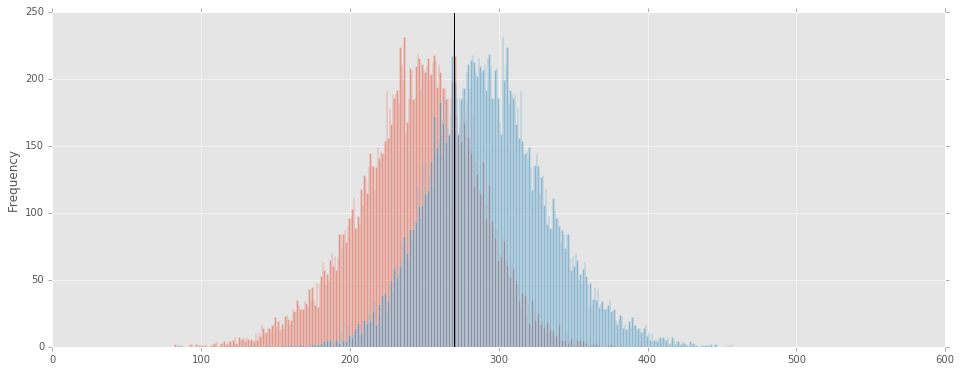

In [138]:
plt.figure(num=None, figsize=(16,6), dpi=80, facecolor='w', edgecolor='k')
agg['Tvotes'].plot.hist(bins=range(0,540,1),alpha=0.5)
agg['Hvotes'].plot.hist(bins=range(0,540,1),alpha=0.5)
plt.axvline(270,color='k')

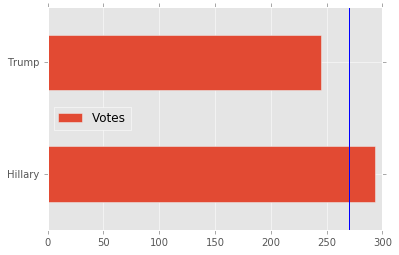

In [139]:
votes = pd.DataFrame(agg[['Hvotes','Tvotes']].mean())
votes.index = ['Hillary','Trump']
votes.columns = ['Votes']
votes.plot.barh(stacked=True)
plt.axvline(270)

In [140]:
dfresults = sims.groupby(['State','Code'])[['Votes','PercIn','Hreal','Treal','Hwins','Twins','Mwins']].mean()
dfresults.sort_values(['Hwins'], ascending=False)

,,Votes,PercIn,Hreal,Treal,Hwins,Twins,Mwins
State,Code,,,,,,,
D.C.,DC,3,0.00,NaN,NaN,0.99970,0.00030,0.0
Michigan,MI,16,0.85,0.48,0.45,0.99945,0.00055,0.0
Maryland,MD,10,0.00,NaN,NaN,0.99850,0.00150,0.0
California,CA,55,0.00,NaN,NaN,0.99780,0.00220,0.0
Massachusetts,MA,11,0.00,NaN,NaN,0.99765,0.00235,0.0
New York,NY,29,0.00,NaN,NaN,0.99325,0.00675,0.0
Hawaii,HI,4,0.00,NaN,NaN,0.97865,0.02135,0.0
Vermont,VT,3,0.00,NaN,NaN,0.97160,0.02840,0.0
Pennsylvania,PA,20,0.80,0.48,0.46,0.97045,0.02955,0.0


In [141]:
dfresults.reset_index(level=0, inplace=True)
state_topo = "https://raw.githubusercontent.com/wrobstory/vincent_map_data/master/us_states.topo.json"
geo_data = [{'name': 'states',
             'url': state_topo,
             'feature': 'us_states.geo'}]

vis = vincent.Map(data=dfresults, geo_data=geo_data, scale=1000,
                  projection='albersUsa', data_bind='Hwins', data_key='State',
                  map_key={'states': 'properties.NAME'}, brew='RdBu')
#Custom threshold scale
vis.scales[0].type='threshold'
vis.scales[0].domain = [0, 0.11,0.22,0.33,0.44, 0.55,0.66,0.77,0.88,1]
vis.legend(title='Hillary win probability')
vis.to_json('vega.json')
vis.display()

NameError: name 'savefig' is not defined